In [28]:
# Cek apakah file sudah diekstrak dengan benar
import os
os.listdir('/kaggle/input/garbage-classification-balanced')

['metal',
 'white-glass',
 'biological',
 'paper',
 'brown-glass',
 'battery',
 'trash',
 'cardboard',
 'shoes',
 'clothes',
 'plastic',
 'green-glass']

In [9]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import zipfile
import shutil
!pip install tensorflowjs
import tensorflowjs as tfjs


# Cek versi TensorFlow
print(f"TensorFlow version: {tf.__version__}")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible

TensorFlow version: 2.18.0


## Data Preparation

### Data Preprocessing

In [ ]:
import os

# Definisikan base_dir untuk data input (read-only)
data_dir = '/kaggle/input/garbage-classification-balanced' # Sesuaikan dengan path dataset di Kaggle

# Definisikan direktori output di /kaggle/working/ (writable)
base_output_dir = '/kaggle/working/garbage_classification_split'
training_dir = os.path.join(base_output_dir, 'Training')
testing_dir = os.path.join(base_output_dir, 'Testing')
validation_dir = os.path.join(base_output_dir, 'Validation')

# Buat direktori dasar untuk output jika belum ada
os.makedirs(base_output_dir, exist_ok=True)
os.makedirs(training_dir, exist_ok=True)
os.makedirs(testing_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

os.listdir(data_dir)

['metal',
 'white-glass',
 'biological',
 'paper',
 'brown-glass',
 'battery',
 'trash',
 'cardboard',
 'shoes',
 'clothes',
 'plastic',
 'green-glass']

In [30]:
# Parameter untuk preprocessing
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 16
NUM_CLASSES = len(os.listdir(data_dir))

### Split Dataset

In [33]:
import os
import shutil
import random

def split_dataset(source_dir, training_dir, testing_dir, validation_dir, test_split_ratio=0.2, val_split_ratio=0.1):
    for class_name in os.listdir(source_dir):
        class_source_dir = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_source_dir):
            continue  # Skip jika bukan folder

        # Pastikan direktori target sudah dibuat (ini bisa dilakukan di luar fungsi juga)
        os.makedirs(os.path.join(training_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(testing_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

        all_files = os.listdir(class_source_dir)
        random.shuffle(all_files) # Acak daftar file

        num_testing = int(len(all_files) * test_split_ratio)
        # Sisa data setelah test split digunakan untuk train + val
        num_for_train_val = len(all_files) - num_testing
        # Hitung validation dari sisa data tersebut
        num_validation = int(num_for_train_val * (val_split_ratio / (1 - test_split_ratio))) # Rasio val dari sisa setelah test

        testing_files = all_files[:num_testing]
        validation_files = all_files[num_testing : num_testing + num_validation]
        training_files = all_files[num_testing + num_validation:]

        # Salin file untuk testing
        for fname in testing_files:
            shutil.copy(os.path.join(class_source_dir, fname),
                        os.path.join(testing_dir, class_name, fname))

        # Salin file untuk validation
        for fname in validation_files:
            shutil.copy(os.path.join(class_source_dir, fname),
                        os.path.join(validation_dir, class_name, fname))

        # Salin file untuk training
        for fname in training_files:
            shutil.copy(os.path.join(class_source_dir, fname),
                        os.path.join(training_dir, class_name, fname))

        # Hapus baris ini karena class_source_dir adalah read-only
        # shutil.rmtree(class_source_dir)

        print(f"Kelas {class_name}: {len(training_files)} training, {len(validation_files)} validasi, {len(testing_files)} testing")

In [34]:
split_dataset(data_dir, training_dir, testing_dir, validation_dir)

# Hitung ulang jumlah gambar
train_count = sum([len(os.listdir(os.path.join(training_dir, folder))) for folder in os.listdir(training_dir)])
val_count = sum([len(os.listdir(os.path.join(validation_dir, folder))) for folder in os.listdir(validation_dir)])
test_count = sum([len(os.listdir(os.path.join(testing_dir, folder))) for folder in os.listdir(testing_dir)])

print(f"Jumlah gambar training: {train_count}")
print(f"Jumlah gambar validasi: {val_count}")
print(f"Jumlah gambar testing: {test_count}")
print(f"Total gambar: {train_count + val_count + test_count}")

Kelas metal: 706 training, 100 validasi, 201 testing
Kelas white-glass: 706 training, 100 validasi, 201 testing
Kelas biological: 706 training, 100 validasi, 201 testing
Kelas paper: 735 training, 105 validasi, 210 testing
Kelas brown-glass: 706 training, 100 validasi, 201 testing
Kelas battery: 706 training, 100 validasi, 201 testing
Kelas trash: 706 training, 100 validasi, 201 testing
Kelas cardboard: 706 training, 100 validasi, 201 testing
Kelas shoes: 1358 training, 193 validasi, 387 testing
Kelas clothes: 1358 training, 193 validasi, 387 testing
Kelas plastic: 706 training, 100 validasi, 201 testing
Kelas green-glass: 706 training, 100 validasi, 201 testing
Jumlah gambar training: 9805
Jumlah gambar validasi: 1391
Jumlah gambar testing: 2793
Total gambar: 13989


## Data Loading

Jumlah kelas: 12
Contoh kelas: ['plastic', 'biological', 'shoes', 'battery', 'brown-glass', 'trash', 'cardboard', 'clothes', 'metal', 'paper']
Jumlah total gambar training: 9805
Jumlah total gambar testing: 2793
Total gambar: 12598


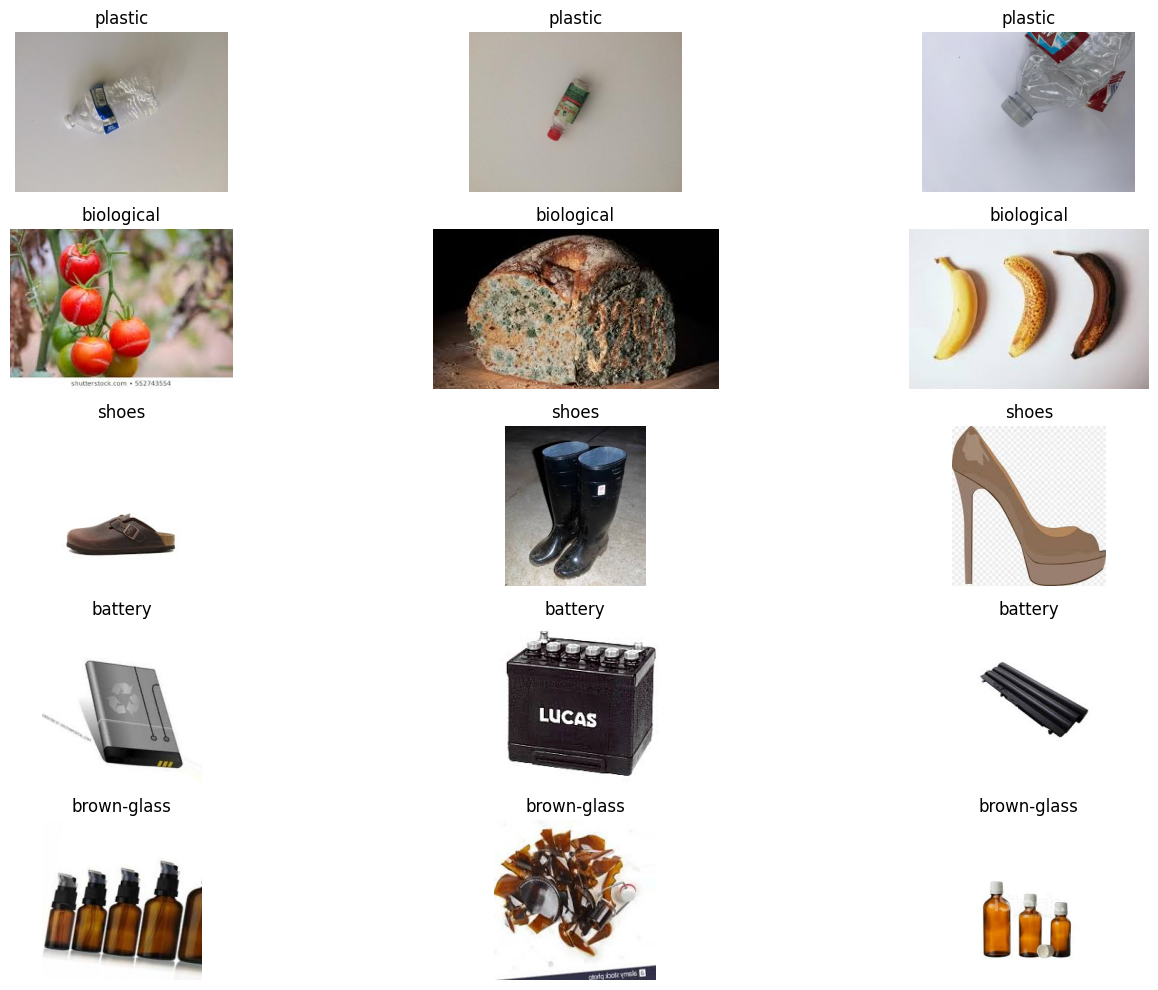

In [36]:

# Tampilkan beberapa informasi tentang dataset
training_dir = os.path.join(base_output_dir, 'Training')
test_dir = os.path.join(base_output_dir, 'Testing')

print("Jumlah kelas:", len(os.listdir(training_dir)))
print("Contoh kelas:", os.listdir(training_dir)[:10])

# Hitung jumlah gambar dalam dataset
total_train_images = sum([len(os.listdir(os.path.join(training_dir, folder))) for folder in os.listdir(training_dir)])
total_test_images = sum([len(os.listdir(os.path.join(test_dir, folder))) for folder in os.listdir(test_dir)])

print(f"Jumlah total gambar training: {total_train_images}")
print(f"Jumlah total gambar testing: {total_test_images}")
print(f"Total gambar: {total_train_images + total_test_images}")

# Visualisasikan beberapa sampel gambar
plt.figure(figsize=(15, 10))

classes = os.listdir(training_dir)[:5]  # Ambil 5 kelas pertama
for i, fruit_class in enumerate(classes):
    class_path = os.path.join(training_dir, fruit_class)
    images = os.listdir(class_path)[:3]  # Ambil 3 gambar dari setiap kelas

    for j, img_file in enumerate(images):
        img_path = os.path.join(class_path, img_file)
        img = plt.imread(img_path)

        plt.subplot(5, 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(fruit_class)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,
    fill_mode = "nearest",
    brightness_range = [0.9, 1.1],
    channel_shift_range = 10.0,
    validation_split = 0.0
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Image generators
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    interpolation="bicubic"
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # Penting untuk validasi dan test agar urutan tidak berubah
    interpolation = "bicubic"
)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    interpolation = "bicubic"
)

# Simpan label
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print("Label mapping:", class_indices)

with open('label.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

# Menghitung class weights
class_labels = train_generator.classes
class_weights_array = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(class_labels),
    y=class_labels
)
class_weights_dict = {i: float(class_weights_array[i]) for i in range(len(np.unique(class_labels)))}

print("Class Weights yang akan digunakan: ", class_weights_dict)


Found 9805 images belonging to 12 classes.
Found 1391 images belonging to 12 classes.
Found 2793 images belonging to 12 classes.
Label mapping: {'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'clothes': 4, 'green-glass': 5, 'metal': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10, 'white-glass': 11}
Class Weights yang akan digunakan:  {0: 1.1573418319169027, 1: 1.1573418319169027, 2: 1.1573418319169027, 3: 1.1573418319169027, 4: 0.6016813942071674, 5: 1.1573418319169027, 6: 1.1573418319169027, 7: 1.1116780045351473, 8: 1.1573418319169027, 9: 0.6016813942071674, 10: 1.1573418319169027, 11: 1.1573418319169027}


## Modelling

In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, 
    Dropout, Dense, GlobalAveragePooling2D, Activation,
    SeparableConv2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
import tensorflow as tf

# Bangun model CNN dengan Sequential API
model = Sequential([
    # Input layer
    Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    
    # Block 1 - Feature extraction
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Block 2 - Increased complexity
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Block 3 - Separable convolutions for efficiency (FIXED)
    SeparableConv2D(128, (3, 3), padding='same', 
                    depthwise_regularizer=regularizers.l2(0.001), 
                    pointwise_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    SeparableConv2D(128, (3, 3), padding='same', 
                    depthwise_regularizer=regularizers.l2(0.001), 
                    pointwise_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Block 4 - Higher level features (FIXED)
    SeparableConv2D(256, (3, 3), padding='same', 
                    depthwise_regularizer=regularizers.l2(0.001), 
                    pointwise_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    SeparableConv2D(256, (3, 3), padding='same', 
                    depthwise_regularizer=regularizers.l2(0.001), 
                    pointwise_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    # Block 5 - Final feature extraction
    Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    # Global Average Pooling 
    GlobalAveragePooling2D(),
    
    # Classification head with proper regularization
    Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    
    Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    
    # Output layer
    Dense(NUM_CLASSES, activation='softmax', name='predictions')
])


# Lihat ringkasan model
model.summary()


# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Siapkan callbacks
callbacks = [
    # Model checkpoint untuk menyimpan model terbaik
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1,
        save_weights_only=False
    ),

    # Early stopping untuk menghentikan training jika tidak ada improvement
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        min_delta = 0.001
    ),

    # Reduce learning rate jika plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1,
        cooldown=2
    )
]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 56, 56, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 56, 56, 128)         │              

 Total params: 1,812,460 (6.91 MB)

 Trainable params: 1,807,724 (6.90 MB)

 Non-trainable params: 4,736 (18.50 KB)

In [33]:
# Train model
EPOCHS = 100
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


Epoch 1/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.2191 - loss: 4.4532
Epoch 1: val_accuracy improved from -inf to 0.07189, saving model to best_model.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 179s 505ms/step - accuracy: 0.2193 - loss: 4.4518 - val_accuracy: 0.0719 - val_loss: 4.8875 - learning_rate: 0.0010
Epoch 2/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.4024 - loss: 3.1559
Epoch 2: val_accuracy improved from 0.07189 to 0.29691, saving model to best_model.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 143s 466ms/step - accuracy: 0.4024 - loss: 3.1555 - val_accuracy: 0.2969 - val_loss: 3.1163 - learning_rate: 0.0010
Epoch 3/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4363 - loss: 2.6126
Epoch 3: val_accuracy did not improve from 0.29691
307/307 ━━━━━━━━━━━━━━━━━━━━ 145s 471ms/step - accuracy: 0.4364 - loss: 2.6123 - val_accuracy: 0.2451 - val_loss: 3.0913 - learning_rate: 0.0010
Epoch 4/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.463

## Evaluasi dan Visualisasi

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.8517 - loss: 0.6372
Test accuracy: 0.8496
Test loss: 0.6338


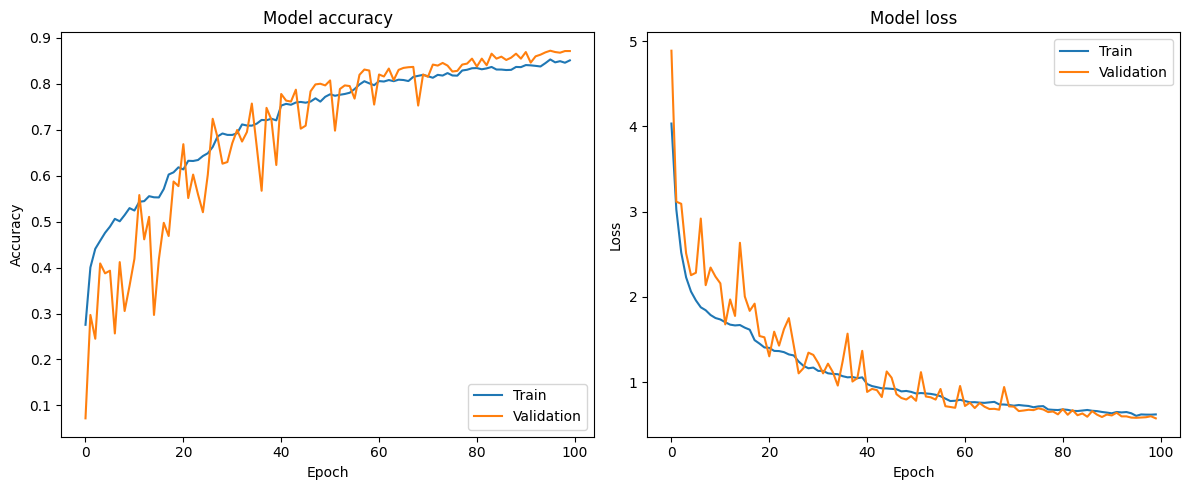

88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step


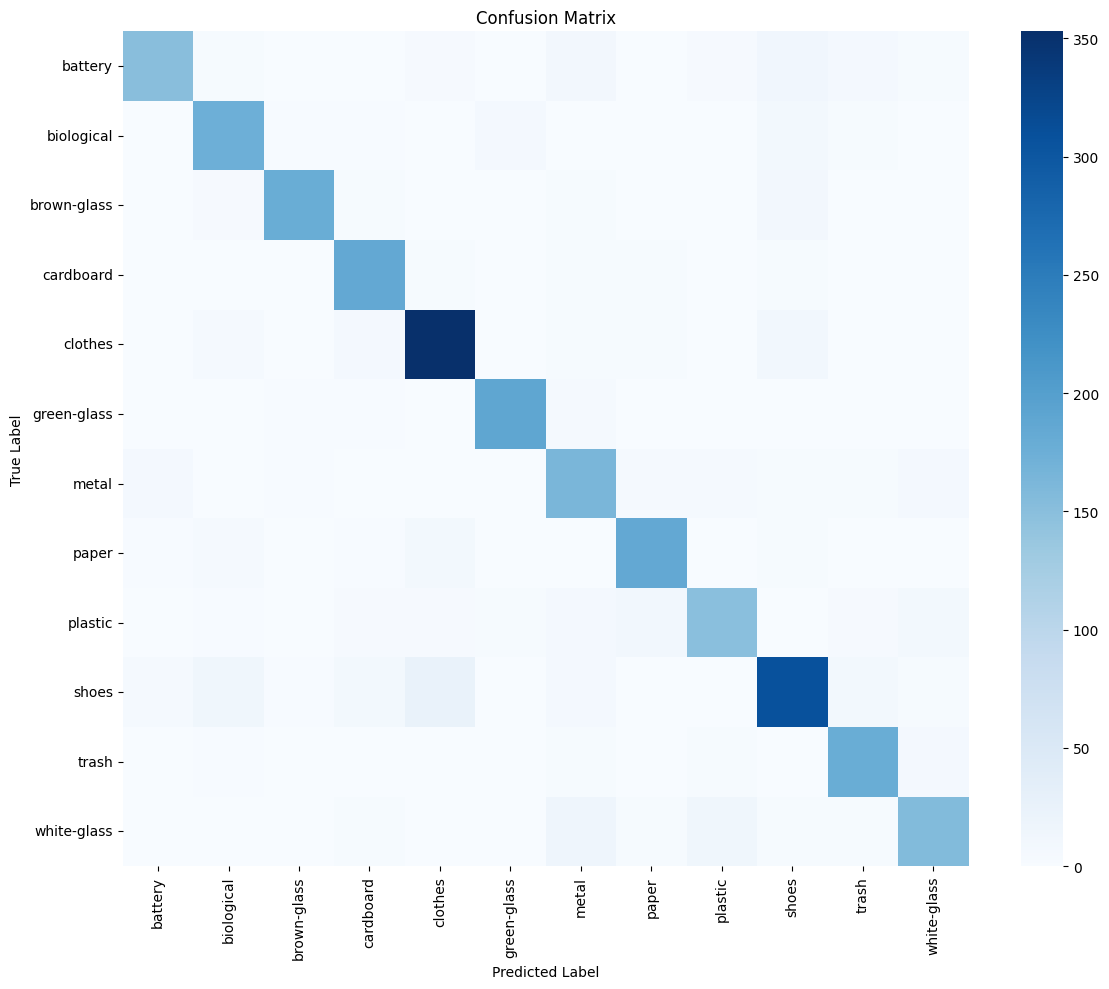

Classification Report:
              precision    recall  f1-score   support

     battery       0.89      0.75      0.82       201
  biological       0.82      0.87      0.84       201
 brown-glass       0.96      0.89      0.92       201
   cardboard       0.84      0.93      0.88       201
     clothes       0.87      0.91      0.89       387
 green-glass       0.92      0.94      0.93       201
       metal       0.72      0.81      0.76       201
       paper       0.86      0.88      0.87       210
     plastic       0.82      0.75      0.78       201
       shoes       0.84      0.80      0.82       387
       trash       0.85      0.89      0.87       201
 white-glass       0.82      0.78      0.80       201

    accuracy                           0.85      2793
   macro avg       0.85      0.85      0.85      2793
weighted avg       0.85      0.85      0.85      2793



In [37]:

# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")
# print(f"Test F1 Score: {test_f1_score:.4f}")

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# Prediksi pada test set
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth
y_true = test_generator.classes

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred_classes)
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


## Konversi Model

In [ ]:
from tensorflow.keras.models import load_model

# 1. Muat model dari file .keras yang sudah ada
print("Memuat model dari best_model.keras...")
model = load_model('/kaggle/working/best_model.keras')

# 2. Simpan kembali model dalam format .h5
print("Menyimpan ulang model ke format best_model.h5...")
model.save('/kaggle/working/best_model.h5')

print("Selesai.")

Memuat model dari best_model.keras...
Menyimpan ulang model ke format best_model.h5...
Selesai.


In [60]:
# Langkah 1: (Opsional tapi sangat disarankan) Verifikasi bahwa file model Anda ada
# Jalankan perintah ini untuk memastikan 'best_model.keras' ada di direktori kerja.
!ls -l /kaggle/working/

# Langkah 2: Jalankan konverter dengan path lengkap

# Konversi file .h5 yang baru
!tensorflowjs_converter --input_format=keras \
                       /kaggle/working/best_model.h5 \
                       /kaggle/working/tfjs_model

total 15620
-rw-r--r-- 1 root root 7994472 Jun  6 19:40 best_model.h5
-rw-r--r-- 1 root root 7990269 Jun  6 19:10 best_model.keras
drwxr-xr-x 5 root root    4096 Jun  6 14:59 garbage_classification_split
-rw-r--r-- 1 root root     105 Jun  6 15:22 label.txt
2025-06-06 19:41:07.841060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749238867.862479    1626 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749238867.870272    1626 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is li

In [ ]:
# Konversi ke TFJS
# Pastikan direktori target untuk TFJS juga konsisten
tfjs_model_dir = '../working/tfjs_model'
os.makedirs(tfjs_model_dir, exist_ok=True)
tfjs.converters.save_keras_model(model, tfjs_model_dir) # Simpan ke direktori yang benar
print(f"Model converted to TensorFlow.js format and saved in {tfjs_model_dir}")


failed to lookup keras version from the file,
    this is likely a weight only file
Model converted to TensorFlow.js format and saved in ../working/tfjs_model


In [ ]:
shutil.make_archive("tfjs_model", "zip", "/kaggle/working/tfjs_model")

'/kaggle/working/tfjs_model.zip'

## Inference 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


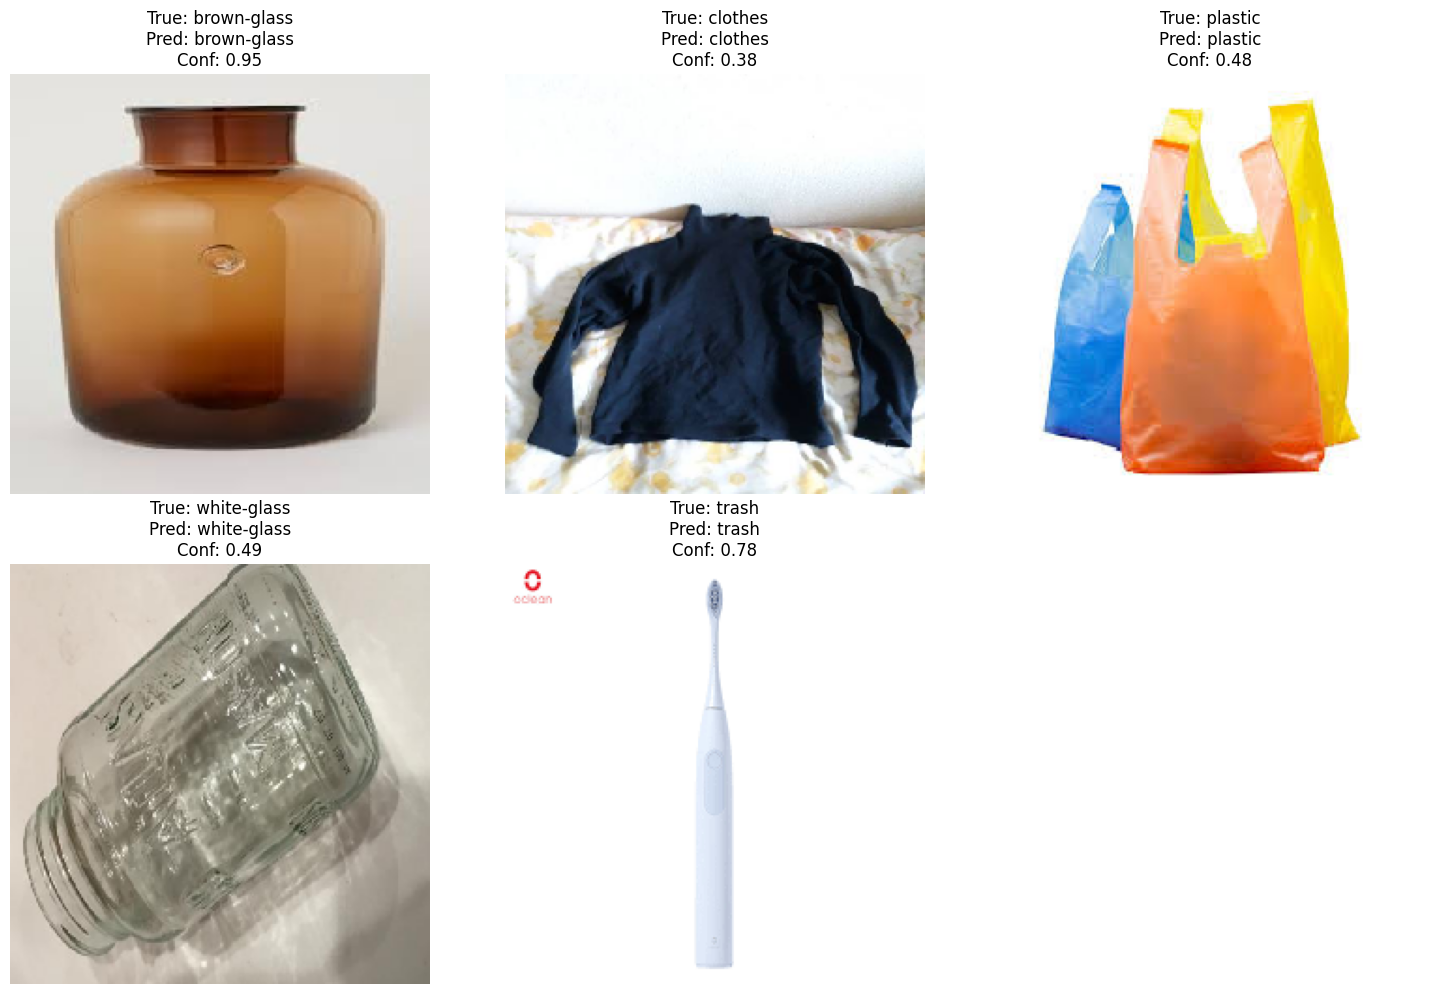

ValueError: Could not open '../working/tflite/model.tflite'.

In [ ]:
import os

# Fungsi untuk melakukan inferensi dengan model
def predict_image(image_path):
    # Load gambar
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Batch dimension

    # Prediksi
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    # Nama kelas
    class_name = class_names[predicted_class]

    return class_name, confidence, img

# Pilih beberapa gambar dari test set untuk inferensi
test_classes = os.listdir(test_dir)
plt.figure(figsize=(15, 10))
random.shuffle(test_classes) # Acak urutan kelas

for i, test_class in enumerate(test_classes[:5]):  # Ambil 5 kelas secara acak
    class_path = os.path.join(test_dir, test_class)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    if images:
        img_path = os.path.join(class_path, random.choice(images)) # Pilih gambar secara acak

        # Prediksi
        class_name, confidence, img = predict_image(img_path)

        # Tampilkan gambar dengan prediksi
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {test_class}\nPred: {class_name}\nConf: {confidence:.2f}")
        plt.axis('off')

plt.tight_layout()
plt.show()